In [1]:
%pip install emcee
%pip install tqdm

Matplotlib is building the font cache; this may take a moment.


Running MCMC...


/lib/python3.12/site-packages/emcee/pbar.py:53: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  return tqdm.tqdm(total=total, **kwargs)
100%|██████████| 5000/5000 [00:03<00:00, 1261.99it/s]



Bayesian Median Fit:
  Effective Modulus E* = 0.58 MPa
  Work of Adhesion W = 34.99 mJ/m²


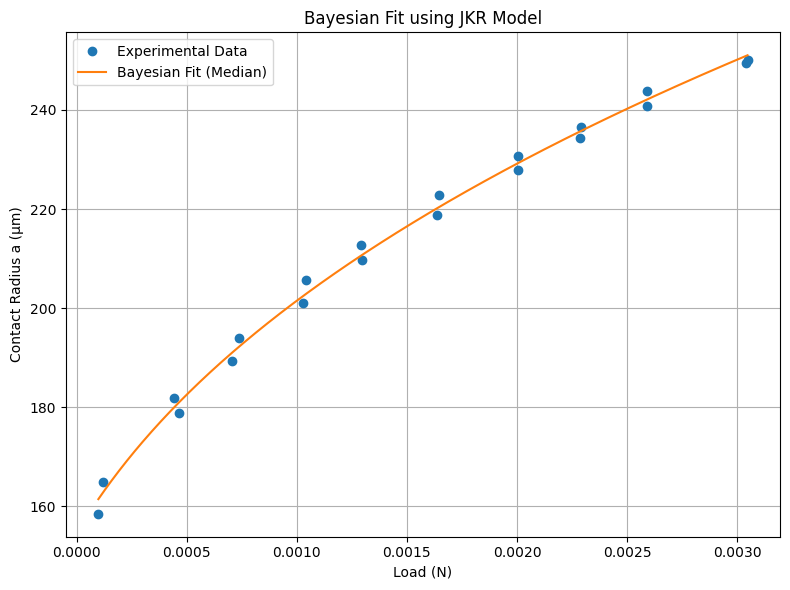

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee

# Load data
df = pd.read_csv('Raw Data Horizontal.csv')
P_data = df['Load (N)'].values
a_data = df['Dip (um)'].values * 1e-6  # Convert to meters

# Known radius
R = 0.00208468  # meters

# JKR model
def jkr_model(P, E_star, W):
    if W <= 0 or E_star <= 0:
        return np.full_like(P, 1e6)  # nonsense output to get rejected
    term1 = P + 3 * np.pi * R * W
    term2 = np.sqrt(6 * np.pi * R * W * P + (3 * np.pi * R * W)**2)
    a_cubed = (3 * R / (4 * E_star)) * (term1 + term2)
    return a_cubed ** (1/3)

# Log-likelihood
def log_likelihood(params, P, a, sigma=5e-8):
    E_star, W = params
    model = jkr_model(P, E_star, W)
    if not np.all(np.isfinite(model)):
        return -np.inf
    return -0.5 * np.sum(((a - model) / sigma) ** 2)

# Log-prior
def log_prior(params):
    E_star, W = params
    if 1e4 < E_star < 1e10 and 1e-6 < W < 1.0:  # E* in Pa, W in J/m²
        return 0.0
    return -np.inf

# Log-posterior
def log_posterior(params, P, a):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, P, a)

# Initialize MCMC
ndim = 2  # [E*, W]
nwalkers = 32
initial = [1e6, 0.05]
pos = initial + 1e4 * np.random.randn(nwalkers, ndim)

# Clip to bounds
for i in range(nwalkers):
    pos[i][0] = np.clip(pos[i][0], 1e4, 1e10)
    pos[i][1] = np.clip(pos[i][1], 1e-6, 1.0)


# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(P_data, a_data))
print("Running MCMC...")
sampler.run_mcmc(pos, 5000, progress=True)

# Get flattened samples after burn-in
samples = sampler.get_chain(discard=1000, thin=10, flat=True)

# Median fit
E_mcmc, W_mcmc = np.median(samples, axis=0)
print(f"\nBayesian Median Fit:")
print(f"  Effective Modulus E* = {E_mcmc * 1e-6:.2f} MPa")
print(f"  Work of Adhesion W = {W_mcmc * 1e3:.2f} mJ/m²")

# Plot posterior fit
P_fit = np.linspace(min(P_data), max(P_data), 500)
a_fit = jkr_model(P_fit, E_mcmc, W_mcmc)

plt.figure(figsize=(8, 6))
plt.plot(P_data, a_data * 1e6, 'o', label='Experimental Data')
plt.plot(P_fit, a_fit * 1e6, '-', label='Bayesian Fit (Median)')
plt.xlabel('Load (N)')
plt.ylabel('Contact Radius a (µm)')
plt.title('Bayesian Fit using JKR Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Individually IN and OUT


Running Bayesian fit for APPROACH...


100%|██████████| 5000/5000 [00:03<00:00, 1283.70it/s]



Running Bayesian fit for LIFT-OFF...


100%|██████████| 5000/5000 [00:03<00:00, 1294.67it/s]



Approach Results:
  Effective modulus E* = 0.58 MPa
  Work of adhesion W = 32.58 mJ/m²

Lift-off Results:
  Effective modulus E* = 0.58 MPa
  Work of adhesion W = 36.40 mJ/m²


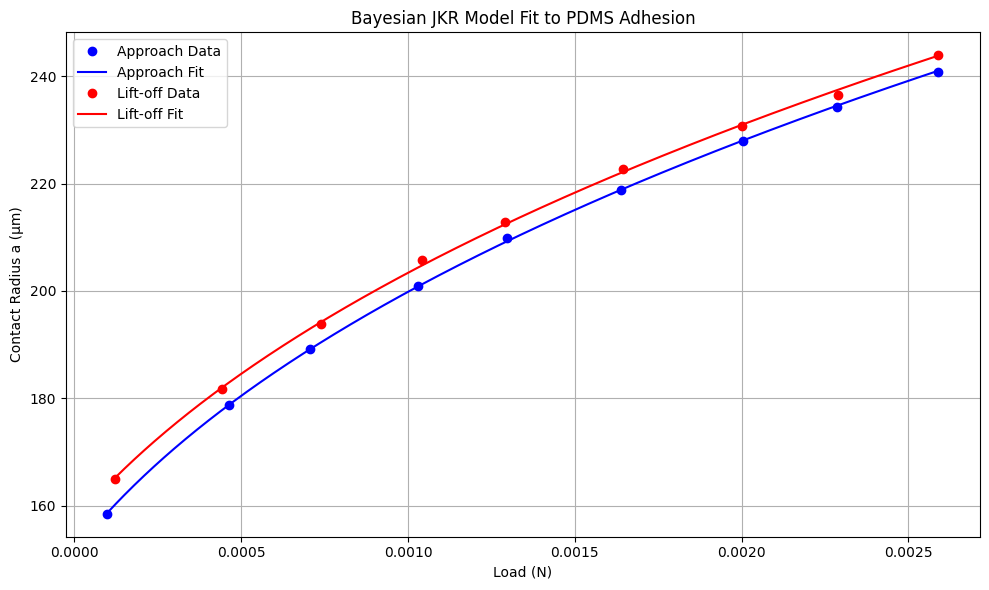

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee

# --- CONSTANTS ---
R = 0.00208468  # PDMS hemisphere radius in meters

# --- LOAD DATA ---
df = pd.read_csv('Raw Data Horizontal.csv')

# JKR model (with safeguard)
def jkr_model(P, E_star, W):
    if W <= 0 or E_star <= 0:
        return np.full_like(P, 1e6)  # return junk if nonphysical
    term1 = P + 3 * np.pi * R * W
    term2 = np.sqrt(6 * np.pi * R * W * P + (3 * np.pi * R * W) ** 2)
    a_cubed = (3 * R / (4 * E_star)) * (term1 + term2)
    return a_cubed ** (1 / 3)

# Log-prior
def log_prior(params):
    E_star, W = params
    if 1e4 < E_star < 1e10 and 1e-6 < W < 1.0:
        return 0.0
    return -np.inf

# Log-likelihood
def log_likelihood(params, P, a_exp, sigma=5e-8):
    model = jkr_model(P, *params)
    if not np.all(np.isfinite(model)):
        return -np.inf
    return -0.5 * np.sum(((a_exp - model) / sigma) ** 2)

# Posterior
def log_posterior(params, P, a_exp):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, P, a_exp)

# Run Bayesian MCMC fit
def run_mcmc(P_data, a_data):
    ndim = 2
    nwalkers = 32
    initial = [1e6, 0.05]
    pos = initial + 1e4 * np.random.randn(nwalkers, ndim)
    for i in range(nwalkers):
        pos[i][0] = np.clip(pos[i][0], 1e4, 1e10)
        pos[i][1] = np.clip(pos[i][1], 1e-6, 1.0)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(P_data, a_data))
    sampler.run_mcmc(pos, 5000, progress=True)
    samples = sampler.get_chain(discard=1000, thin=10, flat=True)
    median_params = np.median(samples, axis=0)
    return median_params, samples

# --- APPROACH DATA ---
df_approach = df.head(9)
P_app = df_approach['Load (N)'].values
a_app = df_approach['Dip (um)'].values * 1e-6  # µm → m

print("\nRunning Bayesian fit for APPROACH...")
params_app, samples_app = run_mcmc(P_app, a_app)
E_star_app = params_app[0] * 1e-6  # Pa → MPa
W_app = params_app[1] * 1e3        # J/m² → mJ/m²

# --- RETRACTION DATA ---
df_retract = df.tail(9)
P_ret = df_retract['Load (N)'].values
a_ret = df_retract['Dip (um)'].values * 1e-6

print("\nRunning Bayesian fit for LIFT-OFF...")
params_ret, samples_ret = run_mcmc(P_ret, a_ret)
E_star_ret = params_ret[0] * 1e-6
W_ret = params_ret[1] * 1e3

# --- PRINT RESULTS ---
print("\nApproach Results:")
print(f"  Effective modulus E* = {E_star_app:.2f} MPa")
print(f"  Work of adhesion W = {W_app:.2f} mJ/m²")

print("\nLift-off Results:")
print(f"  Effective modulus E* = {E_star_ret:.2f} MPa")
print(f"  Work of adhesion W = {W_ret:.2f} mJ/m²")

# --- PLOTTING ---
P_fit_app = np.linspace(min(P_app), max(P_app), 500)
a_fit_app = jkr_model(P_fit_app, *params_app)

P_fit_ret = np.linspace(min(P_ret), max(P_ret), 500)
a_fit_ret = jkr_model(P_fit_ret, *params_ret)

plt.figure(figsize=(10, 6))
plt.plot(P_app, a_app * 1e6, 'bo', label='Approach Data')         # µm
plt.plot(P_fit_app, a_fit_app * 1e6, 'b-', label='Approach Fit')

plt.plot(P_ret, a_ret * 1e6, 'ro', label='Lift-off Data')
plt.plot(P_fit_ret, a_fit_ret * 1e6, 'r-', label='Lift-off Fit')

plt.xlabel('Load (N)')
plt.ylabel('Contact Radius a (µm)')
plt.title('Bayesian JKR Model Fit to PDMS Adhesion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
